<a href="https://colab.research.google.com/github/annadelpozo/MDL-Turing/blob/main/MDL_project_Final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

#Shape inflation and hapinness data
Add the columns from inflation dataset to the hapiness dataset to create our dataframe.
Some country names were different in both datasets so we fixed this manually.
We drop datapoints with no inflation recorded.

In [88]:
inflation = pd.read_csv("/content/global_inflation_data.csv")

inflation.drop(columns = "indicator_name", inplace = True)
for i in inflation.columns[1:]:
  if int(i) < 2015 or int(i) == 2024:
    inflation.drop(columns = i, inplace = True)

data = pd.read_csv("/content/WHI_Inflation 2.csv")
data["Inflation"] = np.nan

name_country_data = ["China", "North Macedonia", "South Sudan", "Swaziland", "Slovakia", "Turkey"]
name_country_infl = ["China, People's Republic of","North Macedonia ","South Sudan, Republic of", "Eswatini", "Slovak Republic","Türkiye, Republic of"]

inflation['country_name'] = inflation['country_name'].replace(name_country_infl, name_country_data)

for index_inf, country_inf in enumerate(inflation["country_name"]):
  for index_data, country_data in enumerate(data["Country"]):
    if country_inf == country_data and (str(data['Year'][index_data]) in inflation.columns[1:]):
      data['Inflation'][index_data]=inflation[str(data['Year'][index_data])][index_inf]

print(data.shape)
data.dropna(subset= "Inflation", inplace = True)
print(data.shape)
data.head()

(1232, 17)
(1228, 17)


,Country,Year,Headline Consumer Price Inflation,Energy Consumer Price Inflation,Food Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,GDP deflator Index growth rate,Continent/Region,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Inflation
0,Afghanistan,2015,-0.660,-4.250000,-0.840000,0.219999,NaN,2.665090,South Asia,3.575,0.319820,0.302850,0.303350,0.23414,0.365100,0.097190,-0.66
1,Afghanistan,2016,4.380,2.070000,5.670000,5.192760,NaN,-2.409509,South Asia,3.360,0.382270,0.110370,0.173440,0.16430,0.312680,0.071120,4.38
2,Afghanistan,2017,4.976,4.440000,6.940000,5.423228,NaN,2.404000,South Asia,3.794,0.401477,0.581543,0.180747,0.10618,0.311871,0.061158,4.98
3,Afghanistan,2018,0.630,1.474185,-1.045952,-0.126033,NaN,2.071208,South Asia,3.632,0.332000,0.537000,0.255000,0.08500,0.191000,0.036000,0.63
4,Afghanistan,2019,2.302,-2.494359,3.794770,NaN,NaN,6.520928,South Asia,3.203,0.350000,0.517000,0.361000,0.00000,0.158000,0.025000,2.30


#Check correlations in our data
We will remove variables with multicollinearity risks, and check to see if the direction of impact on our dependant variable inflation is as expected.

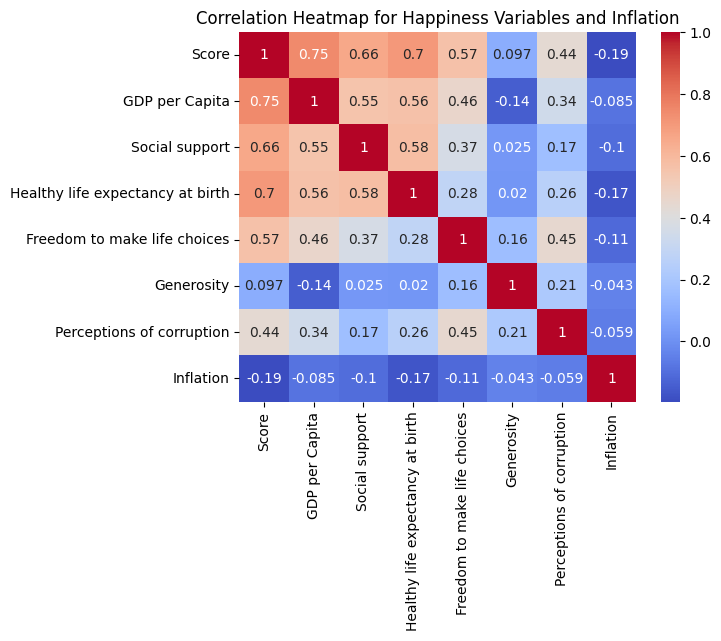

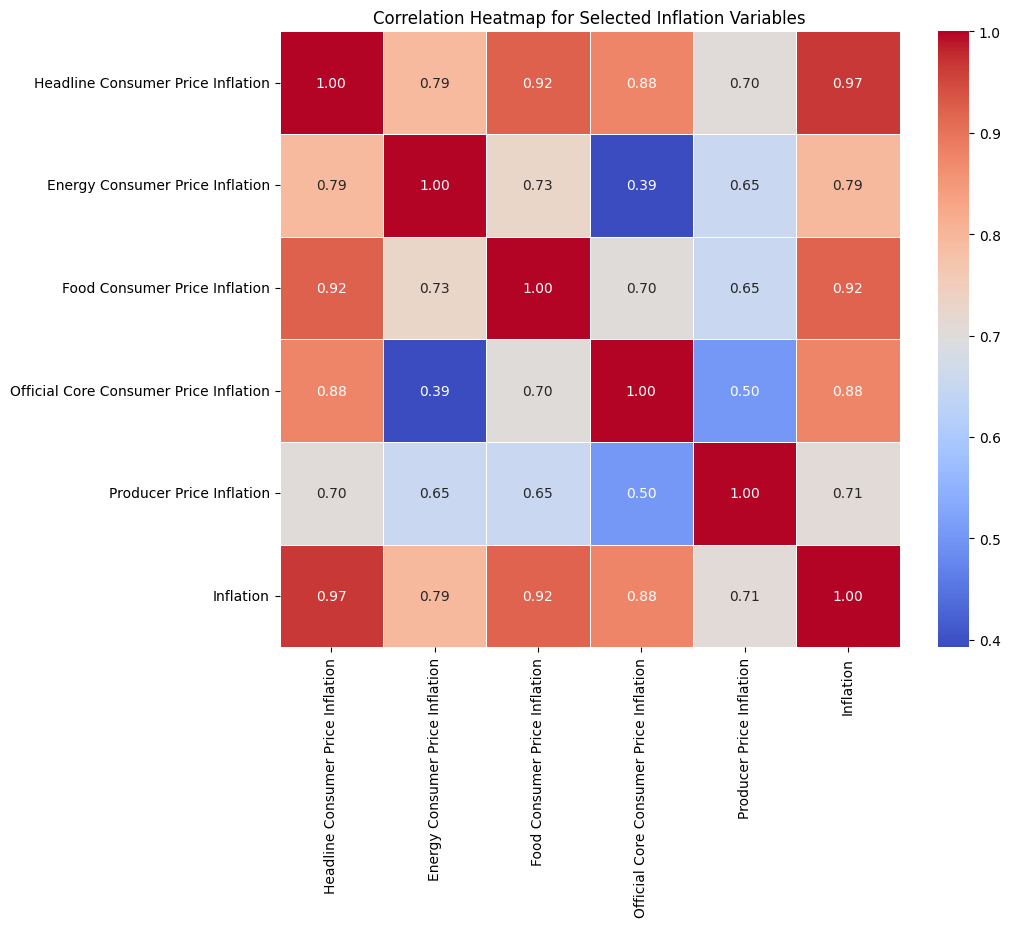

In [89]:
corr_matrix_happy = data.iloc[:,9:17].corr()
sns.heatmap(corr_matrix_happy, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for Happiness Variables and Inflation")
plt.show()

columns_to_select = list(range(2, 7)) + [16]

# Select the columns using their index and name from the DataFrame
numeric_columns_infl = data.iloc[:, columns_to_select]  # Use .iloc for integer-location based indexing

# Calculate the correlation matrix for the selected columns
corr_matrix_infl = numeric_columns_infl.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_infl, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Selected Inflation Variables")
plt.show()

# Lagging the variables + Add Binary Inflation
Goal: include 1 year lags as this empirically makes sense, for each type of inflation.

We also use this code to define our binary variable: 1 if inflation increased from year before, 0 if it decreased.

In [90]:
lagged_variables = ["Energy Consumer Price Inflation", "Food Consumer Price Inflation", "Official Core Consumer Price Inflation", "Producer Price Inflation"]
lagged_names = ["Energy_CPI_lag1", "Food_CPI_lag1", "Official_Core_CPI_lag1", "Producer_price_inflation_lag1"]
for country in data["Country"].unique():
  data.loc[data['Country'] == country, lagged_variables] = data.loc[data['Country'] == country, lagged_variables].shift(1)
  data.loc[data['Country']==country, "Inflation_Binary"] = (data["Inflation"] > data["Inflation"].shift(1)).astype(int)
data = data.rename(columns=dict(zip(lagged_variables, lagged_names)))

data.head(10)


,Country,Year,Headline Consumer Price Inflation,Energy_CPI_lag1,Food_CPI_lag1,Official_Core_CPI_lag1,Producer_price_inflation_lag1,GDP deflator Index growth rate,Continent/Region,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Inflation,Inflation_Binary
0,Afghanistan,2015,-0.660000,NaN,NaN,NaN,NaN,2.665090,South Asia,3.5750,0.319820,0.302850,0.303350,0.23414,0.365100,0.097190,-0.66,0.0
1,Afghanistan,2016,4.380000,-4.250000,-0.840000,0.219999,NaN,-2.409509,South Asia,3.3600,0.382270,0.110370,0.173440,0.16430,0.312680,0.071120,4.38,1.0
2,Afghanistan,2017,4.976000,2.070000,5.670000,5.192760,NaN,2.404000,South Asia,3.7940,0.401477,0.581543,0.180747,0.10618,0.311871,0.061158,4.98,1.0
3,Afghanistan,2018,0.630000,4.440000,6.940000,5.423228,NaN,2.071208,South Asia,3.6320,0.332000,0.537000,0.255000,0.08500,0.191000,0.036000,0.63,0.0
4,Afghanistan,2019,2.302000,1.474185,-1.045952,-0.126033,NaN,6.520928,South Asia,3.2030,0.350000,0.517000,0.361000,0.00000,0.158000,0.025000,2.30,1.0
5,Afghanistan,2020,5.443000,-2.494359,3.794770,NaN,NaN,5.307120,South Asia,2.5669,0.300706,0.356434,0.266052,0.00000,0.135235,0.001226,5.44,1.0
6,Afghanistan,2021,5.062000,NaN,5.829005,NaN,NaN,0.524517,South Asia,2.5230,0.370000,0.000000,0.126000,0.00000,0.122000,0.010000,5.06,0.0
7,Afghanistan,2022,10.600000,NaN,NaN,NaN,NaN,5.475071,South Asia,2.4040,0.758000,0.000000,0.289000,0.00000,0.089000,0.005000,13.71,1.0
8,Afghanistan,2023,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,1.8590,0.645000,0.000000,0.087000,0.00000,0.093000,0.059000,9.10,0.0
9,Albania,2015,1.910179,NaN,NaN,NaN,NaN,0.564278,Central and Eastern Europe,4.9590,0.878670,0.804340,0.813250,0.35733,0.142720,0.064130,1.90,0.0


Now check the new correlation matrix for the inflation lags:

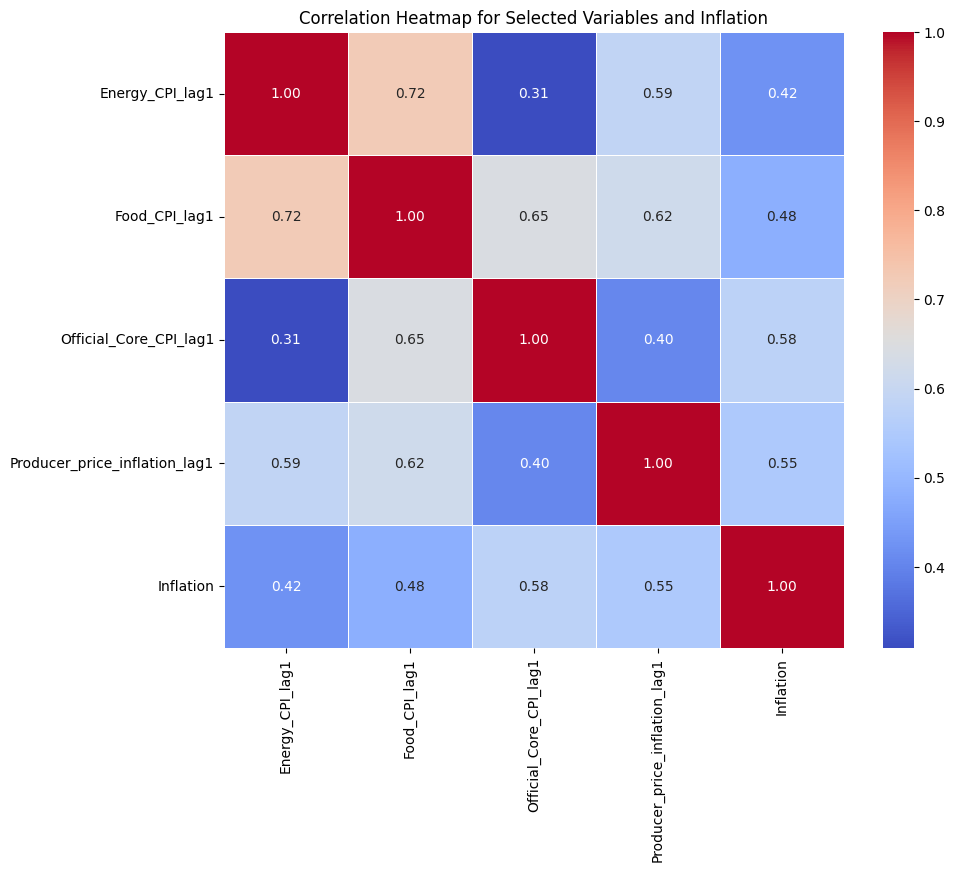

In [91]:
columns_to_select = list(range(3, 7)) + [16]

# Select the columns using their index and name from the DataFrame
numeric_columns_infl = data.iloc[:, columns_to_select]  # Use .iloc for integer-location based indexing

# Calculate the correlation matrix for the selected columns
corr_matrix_infl = numeric_columns_infl.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_infl, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Selected Variables and Inflation")
plt.show()

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 0 to 1231
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country                            1228 non-null   object 
 1   Year                               1228 non-null   int64  
 2   Headline Consumer Price Inflation  1196 non-null   float64
 3   Energy_CPI_lag1                    972 non-null    float64
 4   Food_CPI_lag1                      1001 non-null   float64
 5   Official_Core_CPI_lag1             653 non-null    float64
 6   Producer_price_inflation_lag1      704 non-null    float64
 7   GDP deflator Index growth rate     1208 non-null   float64
 8   Continent/Region                   1228 non-null   object 
 9   Score                              1228 non-null   float64
 10  GDP per Capita                     1228 non-null   float64
 11  Social support                     1228 non-null   float64
 1

#Drop things
Drop columns with missing values (producer and official cpi)

Drop problematic countries with shocks that cause outlier inflation values (this will only bias our model, especially if we do not include country effects).

Drop all remaining NaN rows

Also: create df_encoded and encode by country as a method of including country effects

In [93]:
data.drop(columns = ["GDP deflator Index growth rate", "Headline Consumer Price Inflation", "Continent/Region", "Producer_price_inflation_lag1", "Official_Core_CPI_lag1","Year"], inplace = True)
data.dropna(inplace = True)

countries_to_drop = ["Zimbabwe", "Lebanon", "Argentina","Turkey"]
data = data[~data["Country"].isin(countries_to_drop)]

data_encoded = pd.get_dummies(data, columns=['Country'])
data_encoded.head()
data.drop(columns=["Country"], inplace = True)
print(data.shape,data_encoded.shape)
data.head()

(937, 11) (937, 138)


,Energy_CPI_lag1,Food_CPI_lag1,Score,GDP per Capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Inflation,Inflation_Binary
1,-4.250000,-0.840000,3.3600,0.382270,0.110370,0.173440,0.16430,0.312680,0.071120,4.38,1.0
2,2.070000,5.670000,3.7940,0.401477,0.581543,0.180747,0.10618,0.311871,0.061158,4.98,1.0
3,4.440000,6.940000,3.6320,0.332000,0.537000,0.255000,0.08500,0.191000,0.036000,0.63,0.0
4,1.474185,-1.045952,3.2030,0.350000,0.517000,0.361000,0.00000,0.158000,0.025000,2.30,1.0
5,-2.494359,3.794770,2.5669,0.300706,0.356434,0.266052,0.00000,0.135235,0.001226,5.44,1.0


#Random forrest on inflation binary
(for data, and data_encoded)
1. define X train, test and y train, test
(we use the same split with random state for both models)

In [124]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation_Binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X_enc = data_encoded.drop(columns = ["Inflation", "Inflation_Binary"])
y_enc = data_encoded["Inflation_Binary"]
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.3, random_state=42)
print(X_train_enc.shape, X_test_enc.shape, y_train_enc.shape, y_test_enc.shape)

(749, 9) (188, 9) (749,) (188,)
(655, 136) (282, 136) (655,) (282,)


#We did a grid search for the parameters

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#for not encoded
param_grid = {
    'n_estimators': [5, 10,15, 20],
    "max_depth":[5,10,15],
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt']
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Training Accuracy:", best_model.score(X_train, y_train))
print("Testing Accuracy:", best_model.score(X_test, y_test))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 15}
Training Accuracy: 0.9813084112149533
Testing Accuracy: 0.675531914893617


In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#for encoded
param_grid = {
    'n_estimators': [5, 10, 20, 25, 30, 40,100,150,200,300],
    "max_depth":[5,10,15,20],
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt']
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_enc, y_train_enc)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Training Accuracy:", best_model.score(X_train_enc, y_train_enc))
print("Testing Accuracy:", best_model.score(X_test_enc, y_test_enc))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}
Training Accuracy: 0.751145038167939
Testing Accuracy: 0.6702127659574468


#Forests for Binary inflation using the best parameters

In [125]:
from sklearn.ensemble import RandomForestClassifier as RFC

#Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
modelRFC = RFC(n_estimators=15, max_depth=5, random_state=42)
modelRFC.fit(X_train, y_train)

print("Random Forest binary")

def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))


get_accuracies(modelRFC, X_train, y_train, X_test, y_test)

Random Forest binary
Training score: 0.787716955941255
Testing score:  0.6914893617021277


And for the country encoded data frame:

In [126]:
from sklearn.ensemble import RandomForestClassifier as RFC

modelRFCB = RFC(n_estimators=100, max_depth=15, random_state=42)
modelRFCB.fit(X_train_enc, y_train_enc)

print("Random Forest binary, country encoded")

def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))


get_accuracies(modelRFCB, X_train_enc, y_train_enc, X_test_enc, y_test_enc)

Random Forest binary, country encoded
Training score: 0.9847328244274809
Testing score:  0.7056737588652482


Feature importance

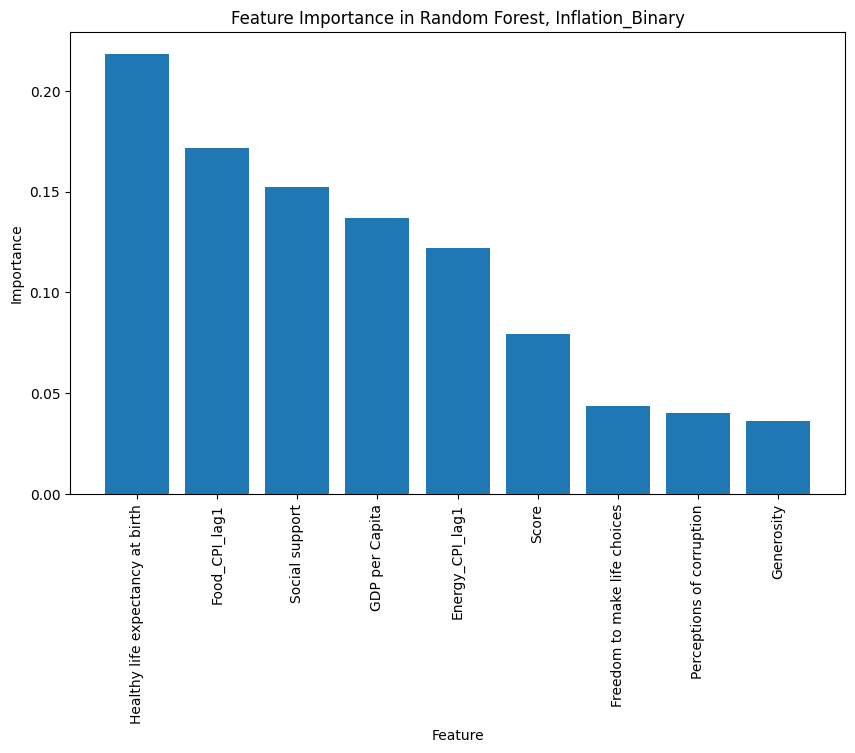

In [127]:
feature_importances = modelRFC.feature_importances_
feature_names = X_train.columns  # Ensure train_X is a DataFrame

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest, Inflation_Binary")
plt.show()

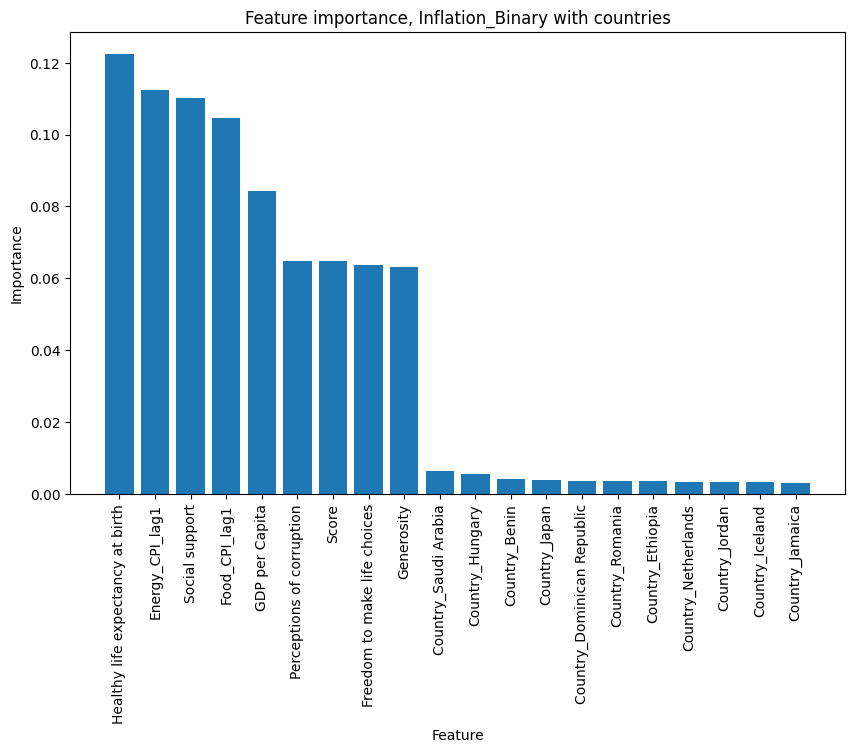

In [119]:
feature_importances = modelRFCB.feature_importances_
feature_names = X_train_enc.columns  # Ensure train_X is a DataFrame

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Select top 20 features
top_n = 20
indices_top = indices[:top_n]

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[indices_top], align="center")
plt.xticks(range(top_n), np.array(feature_names)[indices_top], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importance, Inflation_Binary with countries")
plt.show()

#Random forests to predict the inflation (continuous)


First define new X, y train and test

In [128]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X_enc = data_encoded.drop(columns = ["Inflation", "Inflation_Binary"])
y_enc = data_encoded["Inflation"]
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.3, random_state=42)
print(X_train_enc.shape, X_test_enc.shape, y_train_enc.shape, y_test_enc.shape)

(749, 9) (188, 9) (749,) (188,)
(655, 136) (282, 136) (655,) (282,)


#We ran a grid search and use the best parameters

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

#for non encoded

model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [5,10,15,20,30,40,50,100, 200],      # Number of trees in the forest
    'max_depth': [10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],     # Number of features to consider for the best split
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=mse_scorer,  # Use 'r2' if you prefer R² score
    cv=5,                # 5-fold cross-validation
    verbose=1,
    n_jobs=-1            # Use all available CPU cores
)
grid_search.fit(X_train, y_train)


# Predict on test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate MSE on test data
test_mse = mean_squared_error(y_test, y_pred)
print("Test Set MSE:", test_mse)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Training Accuracy:", best_model.score(X_train, y_train))
print("Testing Accuracy:", best_model.score(X_test, y_test))

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Test Set MSE: 15.27528755899326
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Training Accuracy: 0.9467694591385659
Testing Accuracy: 0.5435481364881218


In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
#fro encoded

model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [5,10,15,20,30,40,50,100, 200],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],     # Number of features to consider for the best split
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=mse_scorer,  # Use 'r2' if you prefer R² score
    cv=5,                # 5-fold cross-validation
    verbose=1,
    n_jobs=-1            # Use all available CPU cores
)
grid_search.fit(X_train_enc, y_train_enc)


# Predict on test data
y_pred_enc = grid_search.best_estimator_.predict(X_test_enc)

# Calculate MSE on test data
test_mse = mean_squared_error(y_test_enc, y_pred_enc)
print("Test Set MSE:", test_mse)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Training Accuracy:", best_model.score(X_train_enc, y_train_enc))
print("Testing Accuracy:", best_model.score(X_test_enc, y_test_enc))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Test Set MSE: 15.972432388016168
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Accuracy: 0.9998263942461596
Testing Accuracy: 0.5255403119211185


#Continuous Inflation forest using best params

In [137]:
from sklearn.ensemble import RandomForestRegressor as RFR

modelRFR = RFR(n_estimators=15, max_depth=5, random_state=42)
modelRFR.fit(X_train, y_train)

print("Random Forest")

def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))


get_accuracies(modelRFR, X_train, y_train, X_test, y_test)

Random Forest
Training score: 0.7579745385154842
Testing score:  0.5116297466986943


And for encoded by country inflation prediction:

In [140]:
from sklearn.ensemble import RandomForestRegressor as RFR

modelRFRE = RFR(n_estimators=50, max_depth=15, random_state=42)
modelRFRE.fit(X_train_enc, y_train_enc)

print("Random Forest")

def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))


get_accuracies(modelRFRE, X_train_enc, y_train_enc, X_test_enc, y_test_enc)

Random Forest
Training score: 0.9119908166668907
Testing score:  0.5375505554082116


#Plot predicted vs true values for normal and encoded data

     True Values  Predictions
393          1.9     1.305533
96           4.9     7.479843
265          1.6     2.022024
820         -2.5     3.512185
863          0.7     2.098721
126          2.8     4.044930
561          8.0     6.175720
115          1.8     2.276915
666          1.0     3.654625
400         17.5     9.346514


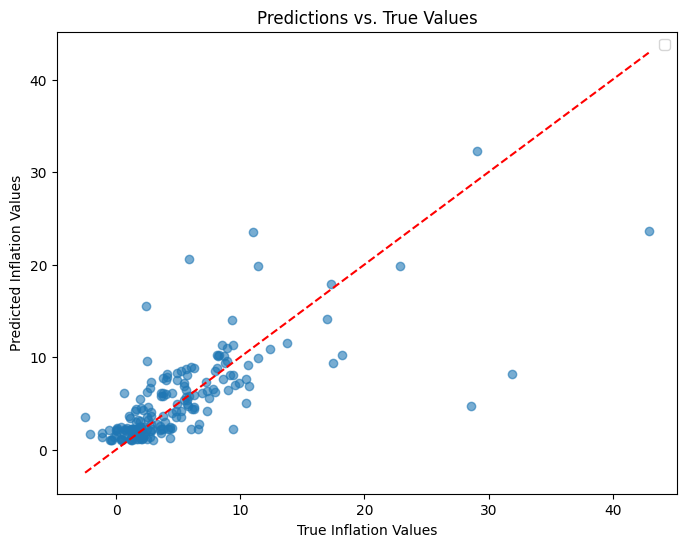

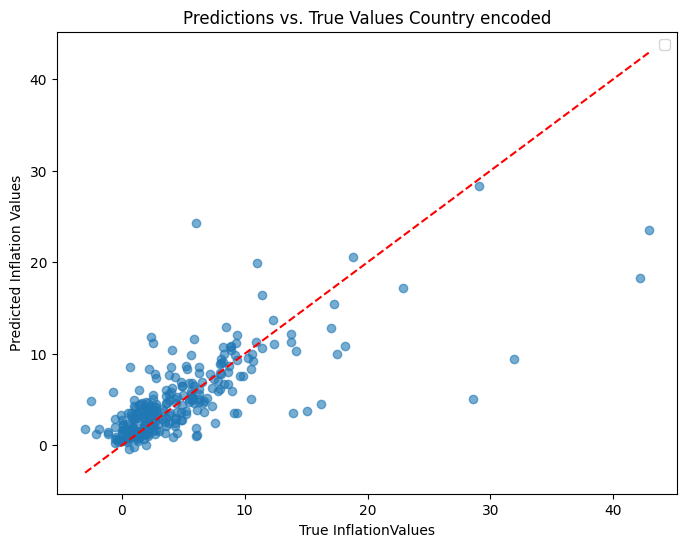

     True Values  Predictions
393          1.9     1.474269
96           4.9     6.522374
265          1.6     1.463378
820         -2.5     4.794481
863          0.7     0.800816
126          2.8     3.796707
561          8.0     6.157544
115          1.8     0.670227
666          1.0     2.923728
400         17.5     9.946533


In [141]:
pred_y = modelRFR.predict(X_test)
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame({"True Values": y_test, "Predictions": pred_y})
print(comparison_df.head(10))

plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_y, alpha=0.6)
plt.xlabel("True Inflation Values")
plt.ylabel("Predicted Inflation Values")
plt.title("Predictions vs. True Values")
plt.legend()
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # 45-degree reference line
plt.show()


pred_y_enc = modelRFRE.predict(X_test_enc)
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame({"True Values": y_test_enc, "Predictions": pred_y_enc})

plt.figure(figsize=(8, 6))
plt.scatter(y_test_enc, pred_y_enc, alpha=0.6)
plt.xlabel("True InflationValues")
plt.ylabel("Predicted Inflation Values")
plt.title("Predictions vs. True Values Country encoded")
plt.legend()
plt.plot([min(y_test_enc), max(y_test_enc)], [min(y_test_enc), max(y_test_enc)], color="red", linestyle="--")  # 45-degree reference line
plt.show()
print(comparison_df.head(10))

#And feature importance:

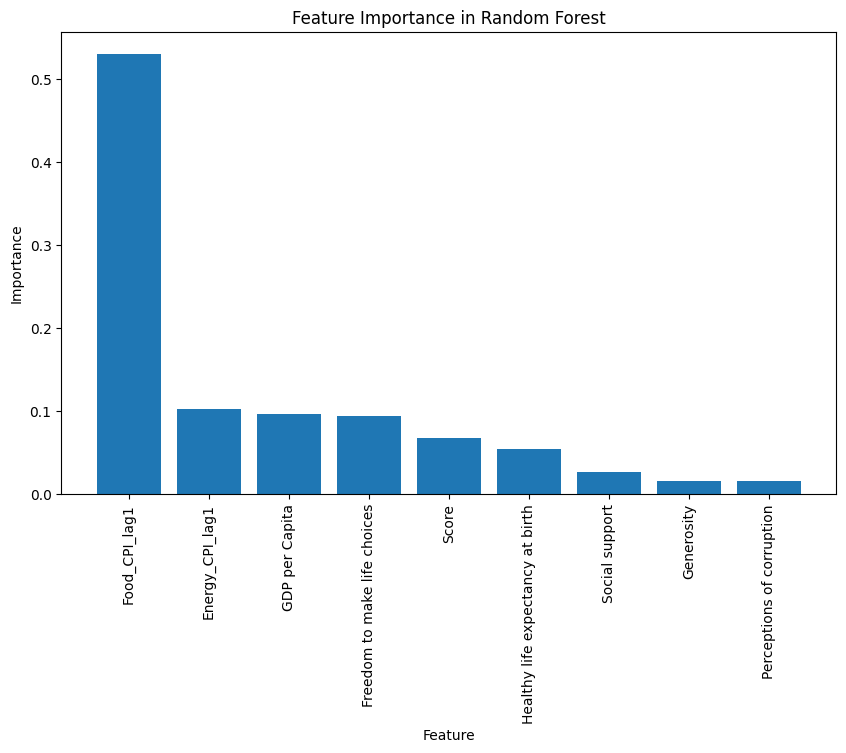

In [142]:
feature_importances = modelRFR.feature_importances_
feature_names = X_train.columns  # Ensure train_X is a DataFrame

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

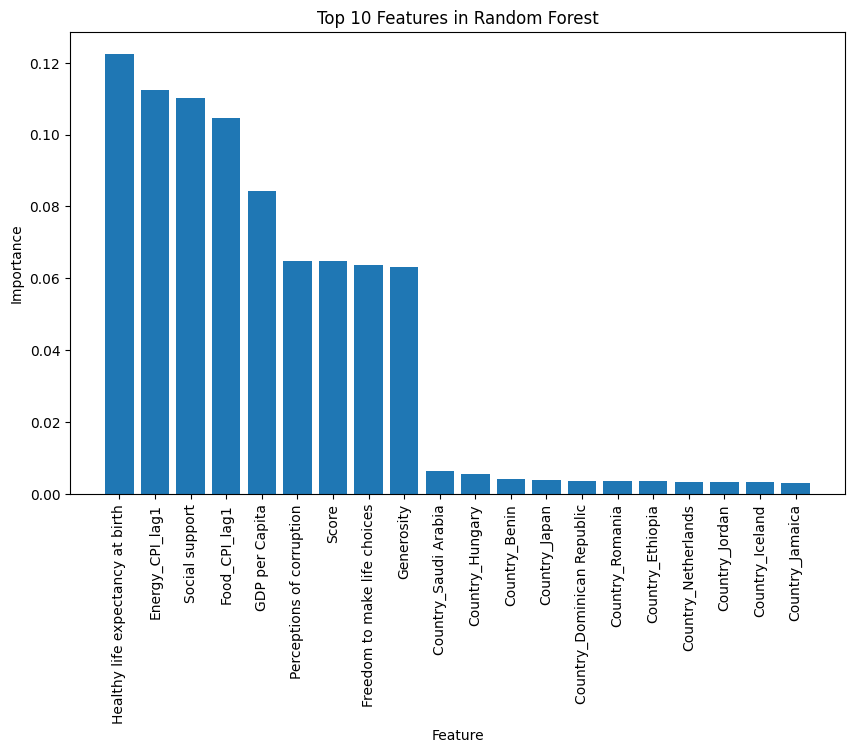

In [143]:
feature_importances = modelRFCB.feature_importances_
feature_names = X_train_enc.columns  # Ensure train_X is a DataFrame

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Select top 20 features
top_n = 20
indices_top = indices[:top_n]

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[indices_top], align="center")
plt.xticks(range(top_n), np.array(feature_names)[indices_top], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 10 Features in Random Forest")
plt.show()

#Can an SVM  work better?

1) On inflation binary

In [144]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation_Binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(749, 9) (188, 9) (749,) (188,)


In [145]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
param_grid_svc = {
    'kernel': ['linear', 'rbf'],  # Kernel types to be tested
    'C': [0.1, 1, 10],                   # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1]  # Kernel coefficient for 'rbf' and 'poly'
}
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Optimize for accuracy
    verbose=1,
    n_jobs=-1           # Use all available CPU cores
)
grid_search_svc.fit(X_train, y_train)
best_svc = grid_search_svc.best_estimator_
print("Best parameters:", grid_search_svc.best_params_)
print("Best accuracy:", grid_search_svc.best_score_)
y_pred = best_svc.predict(X_test)

# Calculate accuracy
print("Inflation Binary SVM:")
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy: 0.6528322147651007
Test Set Accuracy: 0.6648936170212766


2) on inflation (continuous so we use regressor):

In [147]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = ["Inflation", "Inflation_Binary"])
y = data["Inflation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(749, 9) (188, 9) (749,) (188,)


In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define hyperparameter grid
param_grid_svm = {
    'kernel': ['linear', 'rbf'],  # Different kernel functions
    'C': [0.1, 1, 10],  # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
}

# Create the GridSearchCV object
optimal_params_svm = GridSearchCV(
    estimator=SVR(),            # Support Vector Regression model
    param_grid=param_grid_svm,  # Hyperparameter grid
    cv=5,                       # 5-fold cross-validation
    scoring=mae_scorer,
    verbose=1,                  # Show progress
    n_jobs=-1                   # Use all CPU cores
)

# Fit the model
optimal_params_svm.fit(X_train, y_train)
best_svm = optimal_params_svm.best_estimator_

# Print best parameters and score
print("Inflation SVM")
print("Best parameters:", optimal_params_svm.best_params_)
print("Best R² score:", optimal_params_svm.best_score_)
print(get_accuracies(best_svm,X_train,y_train,X_test,y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best R² score: -2.4226185670679556
Training score: 0.5144169006248845
Testing score:  0.49235437108041347
None
